# Image matching example with new kornia local features: TFeat, MKD, OriNet

First, we will install everything needed:

Installing the and pydegensac for good RANSAC

*  fresh version of [kornia](https://github.com/kornia/kornia) for [MKD](https://arxiv.org/pdf/1707.07825.pdf) and [TFeat](http://www.bmva.org/bmvc/2016/papers/paper119/paper119.pdf) descriptors
*  fresh version of OpenCV for SIFT features
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) for the conversions between OpenCV and kornia formats
*  [pydegensac](https://github.com/ducha-aiki/pydegensac) for the robust epipolar geometry estimation


In [ ]:
!pip install git+https://github.com/kornia/kornia
!pip install pydegensac
!pip install kornia_moons
!pip install opencv-python --upgrade

Now let's download an image pair


In [1]:
# Download image pair
!wget https://github.com/kornia/kornia-examples/raw/master/data/matching/kn_church-2.jpg
!wget https://github.com/kornia/kornia-examples/raw/master/data/matching/kn_church-8.jpg


--2023-02-25 17:01:52--  https://github.com/kornia/kornia-examples/raw/master/data/matching/kn_church-2.jpg
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kornia/kornia-examples/master/data/matching/kn_church-2.jpg [following]
--2023-02-25 17:01:53--  https://raw.githubusercontent.com/kornia/kornia-examples/master/data/matching/kn_church-2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 204108 (199K) [image/jpeg]
Saving to: ‘kn_church-2.jpg’

kn_church-2.jpg     100%[===================>] 199,32K  --.-KB/s    in 0,04s   

2023-02-25 17:01:53 (4,85 MB/s) - ‘kn_church-2.jpg’ s

First, we will define image matching pipeline with OpenCV SIFT features. We will also use kornia for the state-of-the-art match filtering -- Lowe ratio + mutual nearest neighbor check and Pydegensac as RANSAC

In [25]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
import pydegensac
from kornia_moons.feature import *

def sift_matching(fname1, fname2):
  img1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)
  
  sift = cv2.SIFT_create(8000)
  kps1, descs1 = sift.detectAndCompute(img1, None)
  kps2, descs2 = sift.detectAndCompute(img2, None)
  dists, idxs = KF.match_smnn(torch.from_numpy(descs1), torch.from_numpy(descs2), 0.95)
  tentatives = cv2_matches_from_kornia(dists, idxs)
  src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
  dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
  F, inliers_mask = pydegensac.findFundamentalMatrix(src_pts, dst_pts, 0.75, 0.99, 100000)
  inliers_mask = inliers_mask.astype(int)
  draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                     singlePointColor = None,
                     matchesMask = inliers_mask.ravel().tolist(), # draw only inliers
                     flags = 2)
  img_out = cv2.drawMatches(img1,kps1,img2,kps2,tentatives,None,**draw_params)
  plt.figure()
  fig, ax = plt.subplots(figsize=(15, 15))
  ax.imshow(img_out, interpolation='nearest')
  print (f'{inliers_mask.sum()} inliers found')
  return   


18 inliers found


<Figure size 432x288 with 0 Axes>

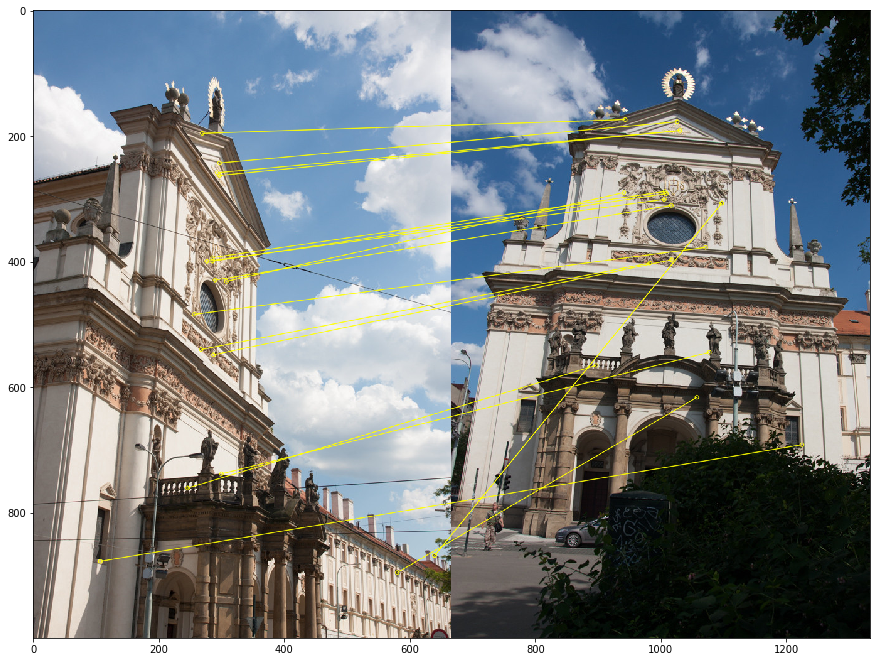

In [26]:

fname1 = 'kn_church-2.jpg'
fname2 = 'kn_church-8.jpg'
sift_matching(fname1, fname2)

Now we need to define a function to feed the OpenCV keypoints into local descriptors from kornia. Luckily, that is easy with the help of kornia_moons.

In [35]:
def get_local_descriptors(img, cv2_sift_kpts, kornia_descriptor):
  if len(cv2_sift_kpts)==0:
    return np.array([])
  
  #We will not train anything, so let's save time and memory by no_grad()
  with torch.no_grad():
    kornia_descriptor.eval()
    timg = K.color.rgb_to_grayscale(K.image_to_tensor(img, False))/255.
    lafs = laf_from_opencv_SIFT_kpts(cv2_sift_kpts)
    patches = KF.extract_patches_from_pyramid(timg,lafs, 32)
    B, N, CH, H, W = patches.size()
    # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
    # So we need to reshape a bit :) 
    descs = kornia_descriptor(patches.view(B * N, CH, H, W)).view(B * N, -1)
  return descs.detach().cpu().numpy()

def sift_korniadesc_matching(fname1, fname2, descriptor):
  img1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)
  
  sift = cv2.SIFT_create(8000)
  kps1 = sift.detect(img1, None)
  kps2 = sift.detect(img2, None)
  # That is the only change in the pipeline -- descriptors
  descs1 = get_local_descriptors(img1, kps1, descriptor)
  descs2 = get_local_descriptors(img2, kps2, descriptor)
  # The rest is the same, as for SIFT

  dists, idxs = KF.match_smnn(torch.from_numpy(descs1), torch.from_numpy(descs2), 0.95)
  tentatives = cv2_matches_from_kornia(dists, idxs)
  src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
  dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
  F, inliers_mask = pydegensac.findFundamentalMatrix(src_pts, dst_pts, 0.75, 0.99, 100000)
  draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = inliers_mask.astype(int).ravel().tolist(), # draw only inliers
                   flags = 2)
  img_out = cv2.drawMatches(img1,kps1,img2,kps2,tentatives,None,**draw_params)
  plt.figure()
  fig, ax = plt.subplots(figsize=(15, 15))
  ax.imshow(img_out, interpolation='nearest')
  print (f'{inliers_mask.sum()} inliers found')

Now let's try kornia new descriptors -- MKD and TFeat. 
MKD is one of the best handcrafted local feature descriptors, presented in IJCV 2018 paper "[Understanding and Improving Kernel Local Descriptors](https://arxiv.org/abs/1811.11147)".


10 inliers found


<Figure size 432x288 with 0 Axes>

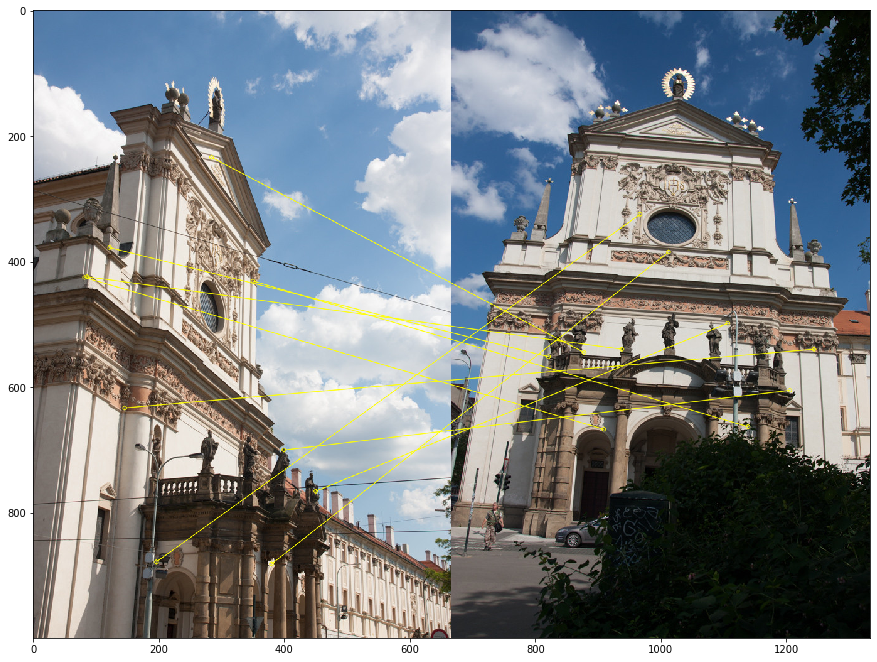

In [36]:
mkd = KF.MKDDescriptor(32)
sift_korniadesc_matching(fname1, fname2, mkd)

Result seems cleaner than with SIFTs. Let's try TFeat - lightweight deep learning-based descriptor from BMVC 2016 paper "[Learning local feature descriptors with triplets and shallow convolutional neural networks](http://www.bmva.org/bmvc/2016/papers/paper119/paper119.pdf)"